In [1]:

"""
Conversion tool for StreamLine .hpl files into netCDF (.nc) files:
    
    - hpl2dict(): import .hpl files and save as dictionary
    - hpl_to_netcdf(): save .hpl files into level0 (l0) .nc files
    - to_netcdf_l1(): correct raw data (l0) and create level1 (l1) netCDF files
    
"""
import numpy as np
from netCDF4 import Dataset
import os
import datetime
import xarray as xr
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import cftime
import os


'''
Import of StreamLine .hpl (txt) files and save locally in directory. Therefore
the data is converted into matrices with dimension "number of range gates" x "time stamp/rays".
In newer versions of the StreamLine software, the spectral width can be 
stored as additional parameter in the .hpl files.
'''
def hpl2dict(file_path):
    #import hpl files into intercal storage
    with open(file_path, 'r') as text_file:
        lines=text_file.readlines()

    #write lines into Dictionary
    data_temp=dict()

    header_n=17 #length of header
    data_temp['filename']=lines[0].split()[-1]
    data_temp['system_id']=int(lines[1].split()[-1])
    data_temp['number_of_gates']=int(lines[2].split()[-1])
    data_temp['range_gate_length_m']=float(lines[3].split()[-1])
    data_temp['gate_length_pts']=int(lines[4].split()[-1])
    data_temp['pulses_per_ray']=int(lines[5].split()[-1])
    data_temp['number_of_waypoints_in_file']=int(lines[6].split()[-1])
    rays_n=(len(lines)-header_n)/(data_temp['number_of_gates']+1)
    
    '''
    number of lines does not match expected format if the number of range gates 
    was changed in the measuring period of the data file (especially possible for stare data)
    '''
    if not rays_n.is_integer():
        print('Number of lines does not match expected format')
        return np.nan
    
    data_temp['no_of_rays_in_file']=int(rays_n)
    data_temp['scan_type']=' '.join(lines[7].split()[2:])
    data_temp['focus_range']=lines[8].split()[-1]
    data_temp['start_time']=' '.join(lines[9].split()[-2:])
    data_temp['resolution']=('%s %s' % (lines[10].split()[-1],'m s-1'))
    data_temp['range_gates']=np.arange(0,data_temp['number_of_gates'])
    data_temp['center_of_gates']=(data_temp['range_gates']+0.5)*data_temp['range_gate_length_m']

    #dimensions of data set
    gates_n=data_temp['number_of_gates']
    rays_n=data_temp['no_of_rays_in_file']

    # item of measurement variables are predefined as symetric numpy arrays filled with NaN values
    data_temp['radial_velocity'] = np.full([gates_n,rays_n],np.nan) #m s-1
    data_temp['intensity'] = np.full([gates_n,rays_n],np.nan) #SNR+1
    data_temp['beta'] = np.full([gates_n,rays_n],np.nan) #m-1 sr-1
    data_temp['spectral_width'] = np.full([gates_n,rays_n],np.nan)
    data_temp['elevation'] = np.full(rays_n,np.nan) #degrees
    data_temp['azimuth'] = np.full(rays_n,np.nan) #degrees
    data_temp['decimal_time'] = np.full(rays_n,np.nan) #hours
    data_temp['pitch'] = np.full(rays_n,np.nan) #degrees
    data_temp['roll'] = np.full(rays_n,np.nan) #degrees
    
    for ri in range(0,rays_n): #loop rays
        lines_temp = lines[header_n+(ri*gates_n)+ri+1:header_n+(ri*gates_n)+gates_n+ri+1]
        header_temp = np.asarray(lines[header_n+(ri*gates_n)+ri].split(),dtype=float)
        data_temp['decimal_time'][ri] = header_temp[0]
        data_temp['azimuth'][ri] = header_temp[1]
        data_temp['elevation'][ri] = header_temp[2]
        data_temp['pitch'][ri] = header_temp[3]
        data_temp['roll'][ri] = header_temp[4]
        for gi in range(0,gates_n): #loop range gates
            line_temp=np.asarray(lines_temp[gi].split(),dtype=float)
            data_temp['radial_velocity'][gi,ri] = line_temp[1]
            data_temp['intensity'][gi,ri] = line_temp[2]
            data_temp['beta'][gi,ri] = line_temp[3]
            if line_temp.size>4:
                data_temp['spectral_width'][gi,ri] = line_temp[4]

    return data_temp

'''
Write .hpl into netCDF l0 data; no data is added, changed or removed;
additional information about institution and contact are optional; 
'''
def hpl_to_netcdf(file_path,path_out,institution=None,contact=None,overwrite=False):
    #check if import file exists
    if not os.path.exists(file_path):
        print('%s cannot be found' %os.path.basename(file_path))
        return
    
    # import data as dictionary
    data_temp = hpl2dict(file_path)
    if type(data_temp) is not dict: return
    
    '''
    Level0 netCDF files will be stored in folder structure which equals the 
    structure on the StreamLine software
    path_out\level0\lidar_id\yyyy\yyyymm\yyyymmdd\file_name.nc
    '''
    datestr=[fns for fns in data_temp['filename'].split('_') if len(fns)==8][0]
    path_out_date=os.path.join(path_out, datestr[0:4], datestr[0:6], datestr)
    # test if file already exists
    if not os.path.exists(path_out_date):
        os.makedirs(path_out_date)

    file_name_out = data_temp['filename'].split('.')[0]+'_l0.nc'
    path_file = os.path.join(path_out_date,file_name_out)
    if os.path.isfile(path_file):
        if overwrite == False:
            raise Exception('%s already exists' % path_file)
        else:
            os.remove(path_file)

    dataset_temp = Dataset(path_file,'w',format ='NETCDF4')
    # define dimensions
    dataset_temp.createDimension('NUMBER_OF_GATES',data_temp['number_of_gates'])
    dataset_temp.createDimension('NUMBER_OF_RAYS',data_temp['no_of_rays_in_file'])
    # Metadata
    dataset_temp.description = "non-processed data of Halo Photonics Streamline"
    if institution:
        dataset_temp.institution = institution
    if contact:
        dataset_temp.contact = contact
    dataset_temp.focus_range = '%s m' % data_temp['focus_range']
    dataset_temp.range_gate_length = '%i m' % data_temp['range_gate_length_m']
    dataset_temp.pulses_per_ray = data_temp['pulses_per_ray']
    dataset_temp.start_time = data_temp['start_time']
    dataset_temp.system_id = data_temp['system_id']
    dataset_temp.scan_type = data_temp['scan_type']
    dataset_temp.resolution = data_temp['resolution']
    dataset_temp.number_waypoint = data_temp['number_of_waypoints_in_file']
    dataset_temp.history = 'File created on %s ' % datetime.datetime.now().strftime('%d %b %Y %H:%M')
    
    decimal_time = dataset_temp.createVariable('decimal_time', np.float64, ('NUMBER_OF_RAYS'))
    decimal_time.units = 'decimal time (hours) UTC'
    decimal_time.long_name = 'start time of each ray'
    decimal_time[:] = data_temp['decimal_time']
    
    azi = dataset_temp.createVariable('azimuth', np.float32, ('NUMBER_OF_RAYS'))
    azi.units = 'degrees, meteorologically'
    azi.long_name = 'azimuth angle'
    azi[:] = data_temp['azimuth']
    
    ele = dataset_temp.createVariable('elevation', np.float32, ('NUMBER_OF_RAYS'))
    ele.units = 'degrees, meteorologically'
    ele.long_name = 'elevation angle'
    ele[:] = data_temp['elevation']
    
    pitch = dataset_temp.createVariable('pitch_angle', np.float32, ('NUMBER_OF_RAYS'))
    pitch.units = 'degrees'
    pitch.long_name = 'pitch angle'
    pitch[:] = data_temp['pitch']
    
    roll = dataset_temp.createVariable('roll_angle', np.float32, ('NUMBER_OF_RAYS'))
    roll.units = 'degrees'
    roll.long_name = 'roll angle'
    roll[:] = data_temp['roll']
    
    rv = dataset_temp.createVariable('radial_velocity', np.float32,('NUMBER_OF_GATES','NUMBER_OF_RAYS'))
    rv.units = 'm s-1'
    rv.long_name = 'Doppler velocity along line of sight'
    rv[:,:] = data_temp['radial_velocity']

    intensity = dataset_temp.createVariable('intensity', np.float32,('NUMBER_OF_GATES','NUMBER_OF_RAYS'))
    intensity.units = 'unitless'
    intensity.long_name = 'SNR + 1'
    intensity[:,:] = data_temp['intensity']
    
    beta = dataset_temp.createVariable('beta', np.float32,('NUMBER_OF_GATES','NUMBER_OF_RAYS'))
    beta.units = 'm-1 sr-1'
    beta.long_name = 'attenuated backscatter'
    beta[:,:] = data_temp['beta']
    
    gate_centers = dataset_temp.createVariable('gate_centers',np.float32,('NUMBER_OF_GATES'))
    gate_centers.units = 'm'
    gate_centers.long_name = 'center of range gates'
    gate_centers[:] = data_temp['center_of_gates']
    dataset_temp.close()
    print('%s is created succesfully' % path_file)

'''
convert level0 netCDF data into level1 netCDF data
input variables:
    file_path       - string
    file_name_out   - string
    lidar_info      - class lidar_location(lat,lon,zsl,name,lidar_id,bearing,gc_corr,pulse_frequency,start_str,end_str,diff_WGS84=np.nan,diff_geoid=np.nan,diff_bessel=np.nan)
    path_out        - string
The lidar_info variables needs the 
'''
def to_netcdf_l1(file_path,file_name_out,lidar_info,path_out):
    
    ds_temp=xr.open_dataset(file_path)
    
    if not os.path.exists(path_out): os.makedirs(path_out)
                    
    ds_temp.azimuth.values=ds_temp.azimuth.values-lidar_info.bearing
    ds_temp.azimuth.attrs['comment']='corrected azimuth angle (az_corrected=az_measured-bearing) --> az_corrected = 0 deg points to geographical North'
    if lidar_info.bearing!=0:
        ds_temp.attrs['description']='corrected data of Halo Photonics Streamline, corrected variables: azimuth'
    elif lidar_info.gc_corr!=0 and lidar_info.bearing!=0:
        ds_temp.attrs['description']='corrected data of Halo Photonics Streamline, corrected variables: azimuth, gate_centers'
    elif lidar_info.gc_corr==0 and lidar_info.bearing==0:
        ds_temp.attrs['description']='corrected data of Halo Photonics Streamline, corrected variables: none'
             
    lat_var=xr.Variable([],lidar_info.lat,\
                        attrs={'units':'decimal degree north',\
                                'long_name':'latitude',\
                                'description':'latitude, north is positive'})
    ds_temp=ds_temp.assign(lat=lat_var)
    
    lon_var=xr.Variable([],lidar_info.lon,\
                        attrs={'units':'decimal degrees east',\
                                'long_name':'longitude',\
                                'description':'longitude, east is positive'})
    ds_temp=ds_temp.assign(lon=lon_var)
    
    
    zsl_var=xr.Variable([],lidar_info.zsl,\
                        attrs={'units':'m',\
                                'long_name':'altitude',\
                                'description':'Height above mean sea leval, Gebrauchshoehe Adria; Transformation to other references is possible by using the additive factor supplied in the fields \"difference_to_geoid\", \"difference_to_bessel\" and \"difference_to_WGS84\", which are added as a list of values, with each entry corresponging to one station, e.g. zsl[1]+zsl.differenve_to_geoid[1] = height above Geoid for the first station',\
                                'difference_to_geoid':lidar_info.diff_geoid,\
                                'difference_to_geoid_descr':'Difference between zsl and height above geoid for each STATION_KEY, e.g. zsl[1] + zsl.difference_to_geoid[1] = Height above Geoid in m',\
                                'difference_to_bessel':lidar_info.diff_bessel,\
                                'difference_to_bessel_descr':'Difference between zsl and height above Bessel 1841 reference ellipsoid for geodetic datum MGI for each STATION_KEY; e.g. zsl[1] + zsl.difference_to_bessel[1] = Height above Bessel ellipsoid in m',\
                                'difference_to_WGS84':lidar_info.diff_WGS84,\
                                'difference_to_WGS_descr':'Difference between zsl and height above WGS84 reference ellipsoid  for each STATION_KEY, e.g., zsl[1] + zsl.difference_to_WGS84[1] = Height above WGS84 ellispoid'})
    ds_temp=ds_temp.assign(zsl=zsl_var)
    
    bearing_var=xr.Variable([],lidar_info.bearing,\
                        attrs={'units':'degrees',\
                                'long_name':'angle of bearing offset',\
                                'description':'angle between the theoretical position of North direction in projected plane (epsg:31254) and North alignment of the instrument: bearing = North_lidar - North_projected ',\
                                'missing_value':-999.})
    ds_temp=ds_temp.assign(bearing=bearing_var)

    dec_time_temp=ds_temp.decimal_time.values
    
    # if data from the next day is collected
    import sys
    if dec_time_temp[-1]<dec_time_temp[0]:
        sys.exit()
    
    date_num=mdates.datestr2num(ds_temp.start_time.split()[0])
    dn_time_temp=date_num+dec_time_temp/24
    date_time=mdates.num2date(dn_time_temp)
    unix_time=[(dt- datetime.datetime(1970,1,1,tzinfo=datetime.timezone.utc)).total_seconds() for dt in date_time]
    
    #dn_time_temp_var=xr.Variable(['NUMBER_OF_RAYS'],dn_time_temp,\
    #                    attrs={'units': 'days since 01-01-0001T00:00:00Z',\
    #                            'long_name':'start time number of each ray'})
    #ds_temp=ds_temp.assign(datenum_time=dn_time_temp_var)
    #seconds since 2022-03-22T14:22:38Z"
    dt_time_temp_var=xr.Variable(['NUMBER_OF_RAYS'],unix_time,\
                        attrs={'units': 'seconds since 01-01-1970T00:00:00Z',\
                                'long_name':'start time number of each ray',\
                                'description':'UNIX timestamp'})
    ds_temp=ds_temp.assign(time=dt_time_temp_var)
       
    path_out_temp = os.path.join(path_out,file_name_out)

    if os.path.isfile(path_out_temp): os.remove(path_out_temp)
    
    ds_temp.to_netcdf(path_out_temp)
    ds_temp.close()


In [50]:
hpl_to_netcdf('/Users/scollis/DL/firstexp/Proc/2022/202212/20221209/Stare_240_20221209_19.hpl', '/Users/scollis/DL/Proc/nc')

/Users/scollis/DL/Proc/nc/2022/202212/20221209/Stare_240_20221209_19_l0.nc is created succesfully


In [51]:
myds = xr.load_dataset('/Users/scollis/DL/Proc/nc/2022/202212/20221209/Stare_240_20221209_19_l0.nc')

In [52]:
myds

<xarray.Dataset>
Dimensions:          (NUMBER_OF_RAYS: 5777, NUMBER_OF_GATES: 500)
Dimensions without coordinates: NUMBER_OF_RAYS, NUMBER_OF_GATES
Data variables:
    decimal_time     (NUMBER_OF_RAYS) float64 19.01 19.01 19.01 ... 19.99 19.99
    azimuth          (NUMBER_OF_RAYS) float32 90.01 90.0 90.0 ... 90.0 90.0 90.0
    elevation        (NUMBER_OF_RAYS) float32 90.0 90.0 90.0 ... 90.0 90.0 90.0
    pitch_angle      (NUMBER_OF_RAYS) float32 0.45 0.45 0.45 ... 0.45 0.45 0.45
    roll_angle       (NUMBER_OF_RAYS) float32 -0.65 -0.65 -0.65 ... -0.65 -0.65
    radial_velocity  (NUMBER_OF_GATES, NUMBER_OF_RAYS) float32 0.4969 ... 4.739
    intensity        (NUMBER_OF_GATES, NUMBER_OF_RAYS) float32 2.392 ... 0.9998
    beta             (NUMBER_OF_GATES, NUMBER_OF_RAYS) float32 7.839e-05 ... ...
    gate_centers     (NUMBER_OF_GATES) float32 12.0 36.0 ... 1.196e+04 1.199e+04
Attributes:
    description:        non-processed data of Halo Photonics Streamline
    focus_range:        65535 m
    range_gate_length:  24 m
    pulses_per_ray:     5000
    start_time:         20221209 19:00:43.13
    system_id:          240
    scan_type:          Stare
    resolution:         0.0382 m s-1
    number_waypoint:    1
    history:            File created on 10 Dec 2022 10:43

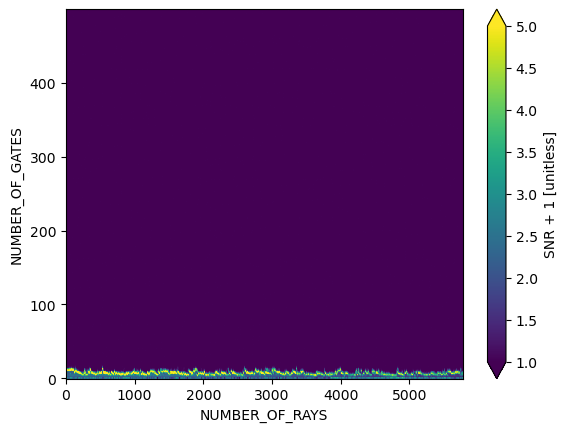

In [53]:
myds.intensity.plot.pcolormesh(vmin=1, vmax=5)

In [46]:
myds = myds.set_index(NUMBER_OF_GATES='gate_centers')

Text(0, 0.5, 'Height')

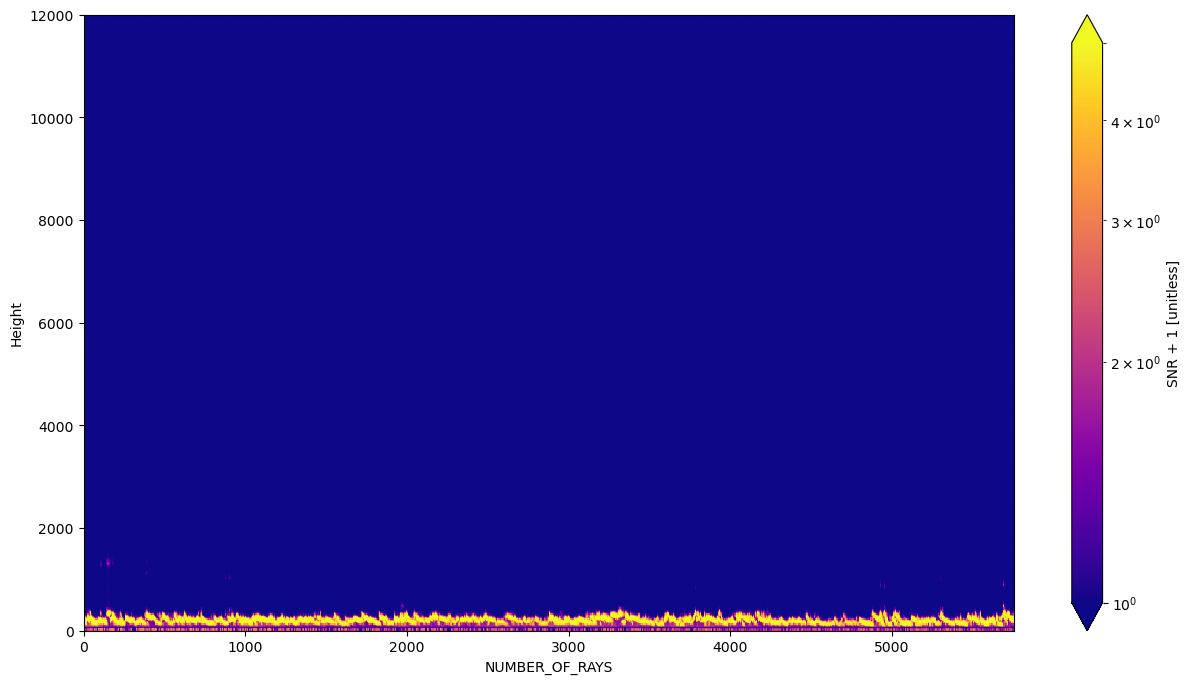

In [48]:
myf = plt.figure(figsize=[15,8])
myds.intensity.plot.pcolormesh( cmap='plasma', norm=LogNorm(vmax=5, vmin=1))
plt.ylabel("Height")

Text(0, 0.5, 'Height')

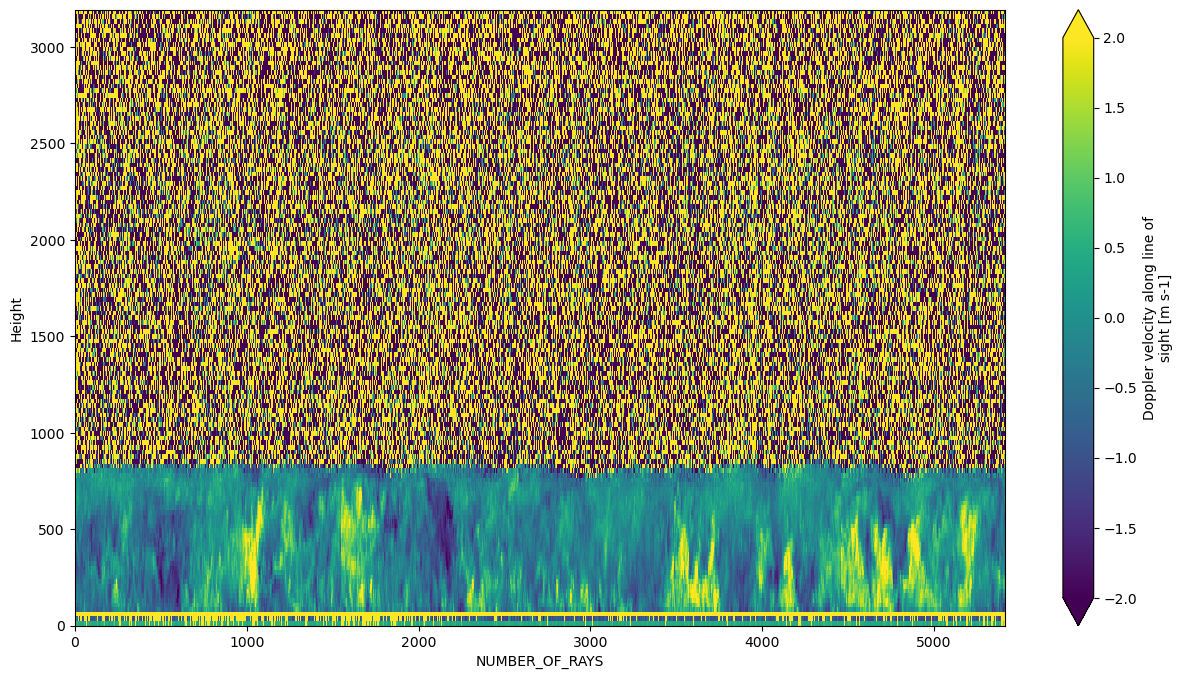

In [12]:
myf = plt.figure(figsize=[15,8])
myds.radial_velocity.plot.pcolormesh( cmap='viridis', vmin=-2, vmax=2)
plt.ylabel("Height")

In [13]:
hpl_to_netcdf('/Users/scollis/DL/Proc/2022/202212/20221208/Stare_240_20221208_03.hpl', '/Users/scollis/DL/Proc/nc')

Exception: /Users/scollis/DL/Proc/nc/2022/202212/20221208/Stare_240_20221208_03_l0.nc already exists

In [14]:
myds = xr.load_dataset('/Users/scollis/DL/Proc/nc/2022/202212/20221208/Stare_240_20221208_03_l0.nc')
myds = myds.set_index(NUMBER_OF_GATES='gate_centers')

Text(0, 0.5, 'Height')

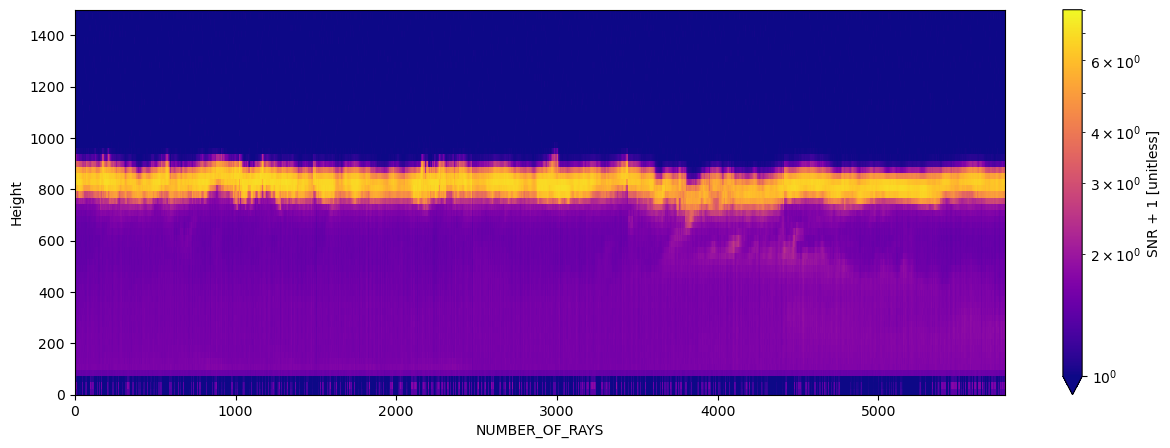

In [15]:
myf = plt.figure(figsize=[15,5])
myds.intensity.plot.pcolormesh( cmap='plasma', norm=LogNorm(vmax=8.0, vmin=1))
plt.ylim([0,1500])
plt.ylabel("Height")

Text(0, 0.5, 'Height')

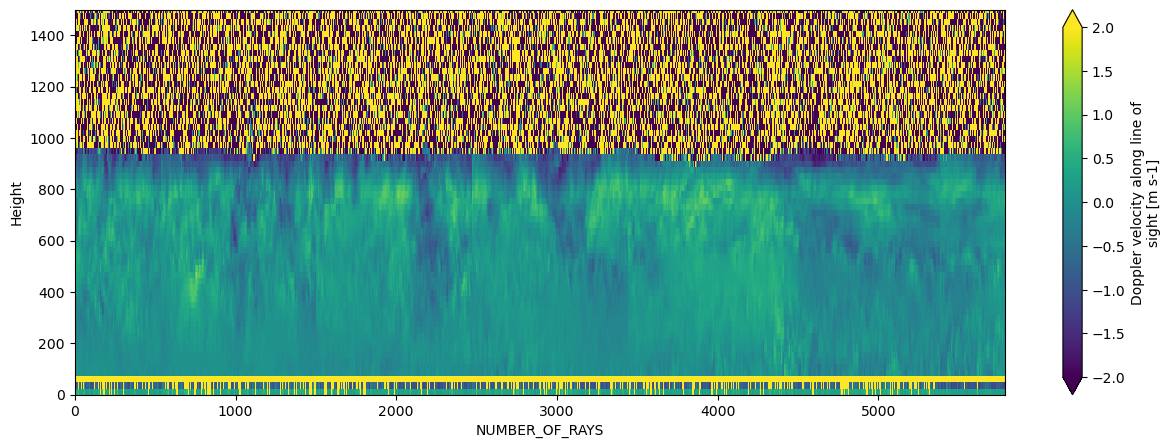

In [16]:
myf = plt.figure(figsize=[15,5])
myds.radial_velocity.plot.pcolormesh( cmap='viridis', vmin=-2, vmax=2)
plt.ylim([0,1500])
plt.ylabel("Height")

In [57]:
class ll:
    lat = 41.7432507
    lon = -87.9600076
    zsl = 200.
    name = 'foo'
    lidar_id ='CMS SDL 001'
    bearing = 0
    gc_corr = 0 
    plus_frequency = 1000
    diff_WGS84=np.nan
    diff_geoid=np.nan
    diff_bessel=np.nan
    
    

In [58]:
my_lidar = ll()

In [6]:
to_netcdf_l1('/Users/scollis/DL/Proc/nc/2022/202212/20221208/Stare_240_20221208_03_l0.nc',
             'magoo',my_lidar, '/Users/scollis/DL/')
mm_da = xr.load_dataset('/Users/scollis/DL/magoo', decode_times=False)
mm_da = xr.decode_cf(mm_da, use_cftime=True)

In [7]:
mm_da = mm_da.set_index(NUMBER_OF_GATES='gate_centers')
mm_da = mm_da.set_index(NUMBER_OF_RAYS='time')

Text(0, 0.5, 'Height')

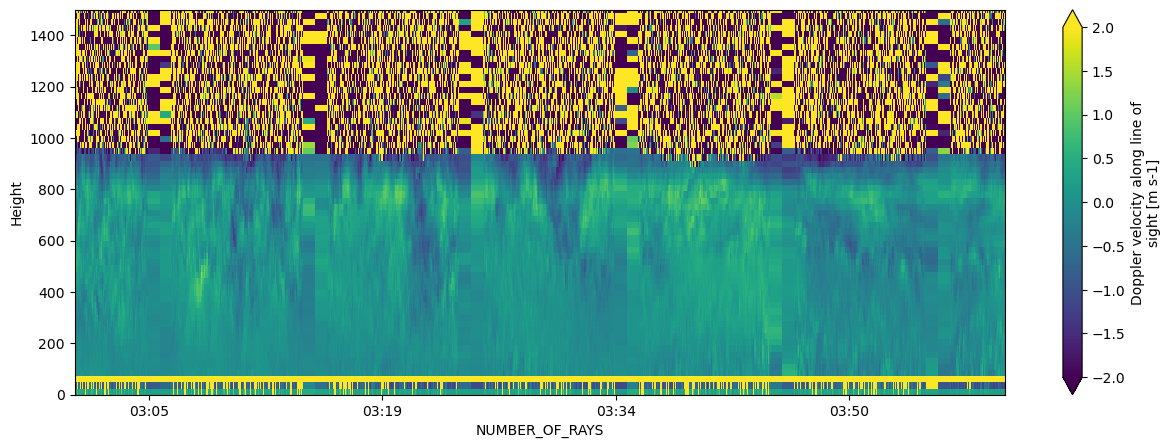

In [8]:
myf = plt.figure(figsize=[15,5])
mm_da.radial_velocity.plot.pcolormesh( cmap='viridis', vmin=-2, vmax=2)
plt.ylim([0,1500])
plt.ylabel("Height")


In [54]:
dolist = []
idir = '/Users/scollis/DL/firstexp/Proc/2022/202212/20221209/'
for file in os.listdir(idir):
    if 'Stare' in file:
        print(file)
        dolist.append(os.path.join(idir, file))
        

Stare_240_20221209_22.hpl
Stare_240_20221209_23.hpl
Stare_240_20221209_21.hpl
Stare_240_20221209_09.hpl
Stare_240_20221209_08.hpl
Stare_240_20221209_20.hpl
Stare_240_20221209_18.hpl
Stare_240_20221209_19.hpl
Stare_240_20221209_03.hpl
Stare_240_20221209_17.hpl
Stare_240_20221209_16.hpl
Stare_240_20221209_02.hpl
Stare_240_20221209_14.hpl
Stare_240_20221209_00.hpl
Stare_240_20221209_01.hpl
Stare_240_20221209_15.hpl
Stare_240_20221209_11.hpl
Stare_240_20221209_05.hpl
Stare_240_20221209_04.hpl
Stare_240_20221209_10.hpl
Stare_240_20221209_06.hpl
Stare_240_20221209_12.hpl
Stare_240_20221209_13.hpl
Stare_240_20221209_07.hpl


In [55]:
for fl in dolist:
    try: 
        hpl_to_netcdf(fl, '/Users/scollis/DL/Proc/nc')
    except:
        print(fl, 'no')

/Users/scollis/DL/Proc/nc/2022/202212/20221209/Stare_240_20221209_22_l0.nc is created succesfully
/Users/scollis/DL/Proc/nc/2022/202212/20221209/Stare_240_20221209_23_l0.nc is created succesfully
/Users/scollis/DL/Proc/nc/2022/202212/20221209/Stare_240_20221209_21_l0.nc is created succesfully
/Users/scollis/DL/Proc/nc/2022/202212/20221209/Stare_240_20221209_09_l0.nc is created succesfully
/Users/scollis/DL/Proc/nc/2022/202212/20221209/Stare_240_20221209_08_l0.nc is created succesfully
/Users/scollis/DL/Proc/nc/2022/202212/20221209/Stare_240_20221209_20_l0.nc is created succesfully
/Users/scollis/DL/Proc/nc/2022/202212/20221209/Stare_240_20221209_18_l0.nc is created succesfully
/Users/scollis/DL/firstexp/Proc/2022/202212/20221209/Stare_240_20221209_19.hpl no
/Users/scollis/DL/Proc/nc/2022/202212/20221209/Stare_240_20221209_03_l0.nc is created succesfully
/Users/scollis/DL/Proc/nc/2022/202212/20221209/Stare_240_20221209_17_l0.nc is created succesfully
/Users/scollis/DL/Proc/nc/2022/20221

In [59]:
idir = '/Users/scollis/DL/Proc/nc/2022/202212/20221209/'
dolist2 = os.listdir(idir)
for newdo in dolist2:
    print(newdo)
    supernewdo = "proc_" + newdo
    to_netcdf_l1(os.path.join(idir,newdo),
             supernewdo , my_lidar, '/Users/scollis/DL/')
    

Stare_240_20221209_04_l0.nc
Stare_240_20221209_20_l0.nc
Stare_240_20221209_22_l0.nc
Stare_240_20221209_06_l0.nc
Stare_240_20221209_02_l0.nc
Stare_240_20221209_19_l0.nc
Stare_240_20221209_00_l0.nc
Stare_240_20221209_23_l0.nc
Stare_240_20221209_07_l0.nc
Stare_240_20221209_05_l0.nc
Stare_240_20221209_21_l0.nc
Stare_240_20221209_18_l0.nc
Stare_240_20221209_01_l0.nc
Stare_240_20221209_03_l0.nc
Stare_240_20221209_16_l0.nc
Stare_240_20221209_14_l0.nc
Stare_240_20221209_10_l0.nc
Stare_240_20221209_09_l0.nc
Stare_240_20221209_12_l0.nc
Stare_240_20221209_15_l0.nc
Stare_240_20221209_17_l0.nc
Stare_240_20221209_13_l0.nc
Stare_240_20221209_11_l0.nc
Stare_240_20221209_08_l0.nc


In [60]:
mm_da = xr.open_mfdataset('/Users/scollis/DL/proc_Stare_240_20221209_*.nc', 
                          concat_dim='NUMBER_OF_RAYS', combine='nested')
sf = xr.load_dataset('/Users/scollis/DL/proc_Stare_240_20221209_00_l0.nc')
gvar = sf.gate_centers
mm_da['Centerofgate'] = gvar
mm_da = mm_da.sortby(mm_da.time).set_index(NUMBER_OF_GATES='Centerofgate')
mm_da = mm_da.set_index(NUMBER_OF_RAYS='time')

In [61]:
mm_da

<xarray.Dataset>
Dimensions:          (NUMBER_OF_RAYS: 137857, NUMBER_OF_GATES: 500)
Coordinates:
  * NUMBER_OF_GATES  (NUMBER_OF_GATES) float32 12.0 36.0 ... 1.196e+04 1.199e+04
  * NUMBER_OF_RAYS   (NUMBER_OF_RAYS) datetime64[ns] 2022-12-09T00:00:10.7600...
Data variables: (12/13)
    decimal_time     (NUMBER_OF_RAYS) float64 dask.array<chunksize=(5688,), meta=np.ndarray>
    azimuth          (NUMBER_OF_RAYS) float32 dask.array<chunksize=(5688,), meta=np.ndarray>
    elevation        (NUMBER_OF_RAYS) float32 dask.array<chunksize=(5688,), meta=np.ndarray>
    pitch_angle      (NUMBER_OF_RAYS) float32 dask.array<chunksize=(5688,), meta=np.ndarray>
    roll_angle       (NUMBER_OF_RAYS) float32 dask.array<chunksize=(5688,), meta=np.ndarray>
    radial_velocity  (NUMBER_OF_GATES, NUMBER_OF_RAYS) float32 dask.array<chunksize=(500, 5688), meta=np.ndarray>
    ...               ...
    beta             (NUMBER_OF_GATES, NUMBER_OF_RAYS) float32 dask.array<chunksize=(500, 5688), meta=np.ndarray>
    gate_centers     (NUMBER_OF_RAYS, NUMBER_OF_GATES) float32 dask.array<chunksize=(5688, 500), meta=np.ndarray>
    lat              (NUMBER_OF_RAYS) float64 41.74 41.74 41.74 ... 41.74 41.74
    lon              (NUMBER_OF_RAYS) float64 -87.96 -87.96 ... -87.96 -87.96
    zsl              (NUMBER_OF_RAYS) float64 200.0 200.0 200.0 ... 200.0 200.0
    bearing          (NUMBER_OF_RAYS) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    description:        corrected data of Halo Photonics Streamline, correcte...
    focus_range:        65535 m
    range_gate_length:  24 m
    pulses_per_ray:     5000
    start_time:         20221209 00:00:11.28
    system_id:          240
    scan_type:          Stare
    resolution:         0.0382 m s-1
    number_waypoint:    1
    history:            File created on 10 Dec 2022 10:46

Text(0, 0.5, 'Height')

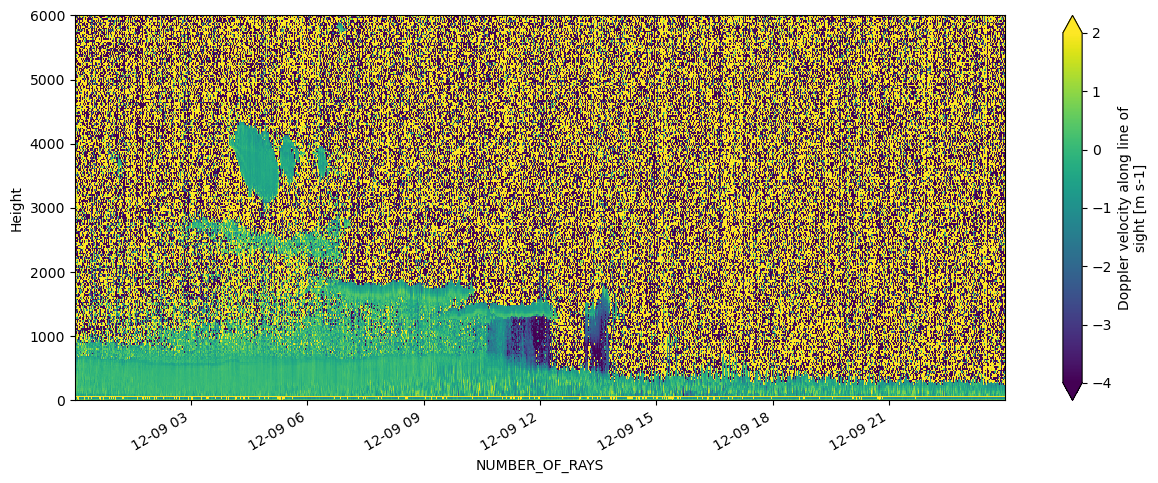

In [69]:
myf = plt.figure(figsize=[15,5])
mm_da.radial_velocity.plot.pcolormesh( cmap='viridis', vmin=-4, vmax=2)
plt.ylim([0,6000])
plt.ylabel("Height")


Text(0, 0.5, 'Height')

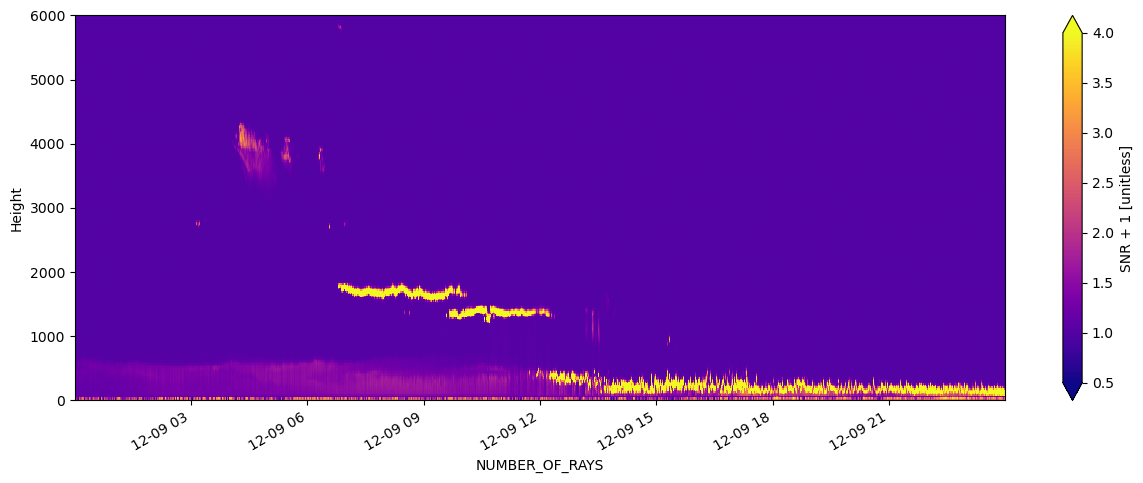

In [71]:
myf = plt.figure(figsize=[15,5])
mm_da.intensity.plot.pcolormesh( cmap='plasma', vmax=4.0, vmin=0.5)
plt.ylim([0,6000])
plt.ylabel("Height")

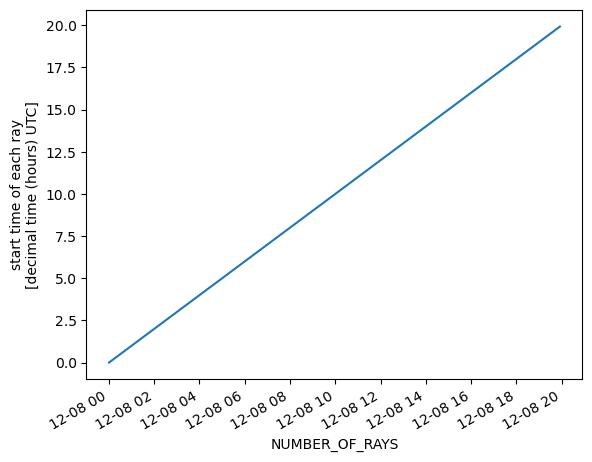

In [29]:
mm_da.decimal_time.plot()

mm_da.

In [32]:
mm_da = xr.open_mfdataset('/Users/scollis/DL/proc_Stare_240_20221208_*.nc', 
                          concat_dim='NUMBER_OF_RAYS', combine='nested')

In [33]:
mm_da.sortby(mm_da.time)

<xarray.Dataset>
Dimensions:          (NUMBER_OF_RAYS: 115350, NUMBER_OF_GATES: 133)
Dimensions without coordinates: NUMBER_OF_RAYS, NUMBER_OF_GATES
Data variables: (12/14)
    decimal_time     (NUMBER_OF_RAYS) float64 dask.array<chunksize=(5757,), meta=np.ndarray>
    azimuth          (NUMBER_OF_RAYS) float32 dask.array<chunksize=(5757,), meta=np.ndarray>
    elevation        (NUMBER_OF_RAYS) float32 dask.array<chunksize=(5757,), meta=np.ndarray>
    pitch_angle      (NUMBER_OF_RAYS) float32 dask.array<chunksize=(5757,), meta=np.ndarray>
    roll_angle       (NUMBER_OF_RAYS) float32 dask.array<chunksize=(5757,), meta=np.ndarray>
    radial_velocity  (NUMBER_OF_GATES, NUMBER_OF_RAYS) float32 dask.array<chunksize=(133, 5757), meta=np.ndarray>
    ...               ...
    gate_centers     (NUMBER_OF_RAYS, NUMBER_OF_GATES) float32 dask.array<chunksize=(5757, 133), meta=np.ndarray>
    lat              (NUMBER_OF_RAYS) float64 41.74 41.74 41.74 ... 41.74 41.74
    lon              (NUMBER_OF_RAYS) float64 -87.96 -87.96 ... -87.96 -87.96
    zsl              (NUMBER_OF_RAYS) float64 200.0 200.0 200.0 ... 200.0 200.0
    bearing          (NUMBER_OF_RAYS) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    time             (NUMBER_OF_RAYS) datetime64[ns] dask.array<chunksize=(5757,), meta=np.ndarray>
Attributes:
    description:        corrected data of Halo Photonics Streamline, correcte...
    focus_range:        65535 m
    range_gate_length:  24 m
    pulses_per_ray:     5000
    start_time:         20221208 00:00:14.28
    system_id:          240
    scan_type:          Stare
    resolution:         0.0382 m s-1
    number_waypoint:    1
    history:            File created on 08 Dec 2022 20:56

In [75]:
dolist = []
idir = '/Users/scollis/DL/firstexp/Proc/2022/202212/20221208/'
for file in os.listdir(idir):
    if 'Stare' in file:
        print(file)
        dolist.append(os.path.join(idir, file))

for fl in dolist:
    try: 
        hpl_to_netcdf(fl, '/Users/scollis/DL/Proc/nc')
    except:
        print(fl, 'no')

idir = '/Users/scollis/DL/Proc/nc/2022/202212/20221208/'
dolist2 = os.listdir(idir)
for newdo in dolist2:
    print(newdo)
    supernewdo = "proc_" + newdo
    to_netcdf_l1(os.path.join(idir,newdo),
             supernewdo , my_lidar, '/Users/scollis/DL/choo/')
    
mm_da2 = xr.open_mfdataset('/Users/scollis/DL/choo/proc_Stare_240_20221208_*.nc', 
                          concat_dim='NUMBER_OF_RAYS', combine='nested')
sf2 = xr.load_dataset('/Users/scollis/DL/choo/proc_Stare_240_20221208_23_l0.nc')
gvar2 = sf2.gate_centers
mm_da2['Centerofgate'] = gvar2
mm_da2 = mm_da2.sortby(mm_da2.time).set_index(NUMBER_OF_GATES='Centerofgate')
mm_da2 = mm_da2.set_index(NUMBER_OF_RAYS='time')
    

Stare_240_20221208_21.hpl
Stare_240_20221208_23.hpl
Stare_240_20221208_22.hpl
/Users/scollis/DL/firstexp/Proc/2022/202212/20221208/Stare_240_20221208_21.hpl no
/Users/scollis/DL/firstexp/Proc/2022/202212/20221208/Stare_240_20221208_23.hpl no
/Users/scollis/DL/firstexp/Proc/2022/202212/20221208/Stare_240_20221208_22.hpl no
Stare_240_20221208_22_l0.nc
Stare_240_20221208_23_l0.nc
Stare_240_20221208_21_l0.nc


Text(0, 0.5, 'Height')

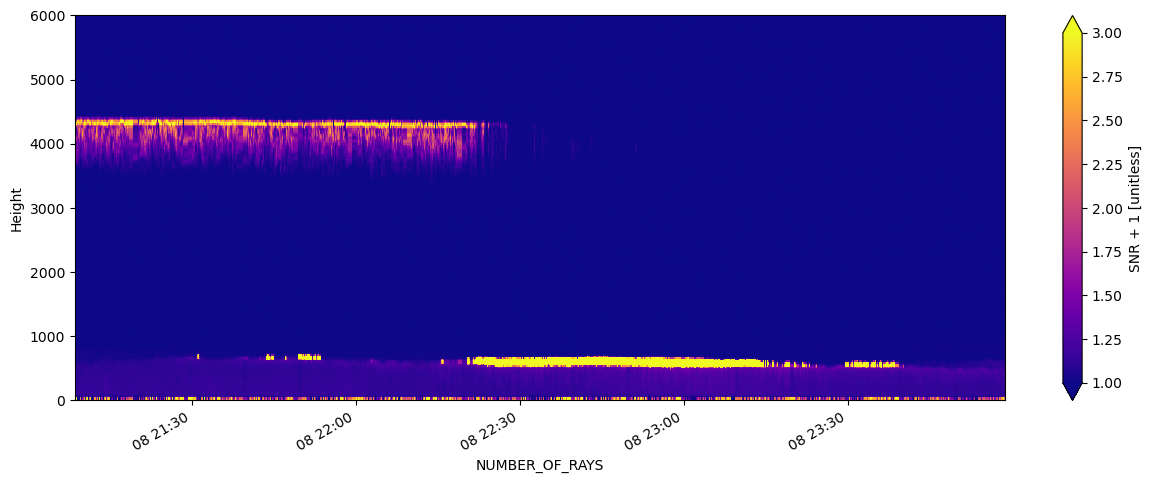

In [79]:
myf = plt.figure(figsize=[15,5])
mm_da2.intensity.plot.pcolormesh( cmap='plasma', vmax=3.0, vmin=1.0)
plt.ylim([0,6000])
plt.ylabel("Height")

Text(0, 0.5, 'Height')

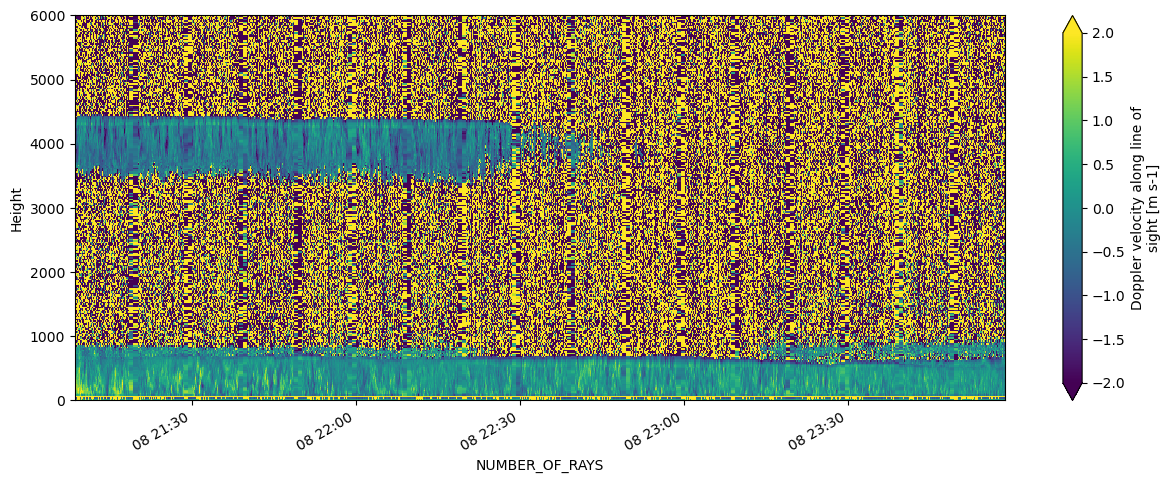

In [81]:
myf = plt.figure(figsize=[15,5])
mm_da2.radial_velocity.plot.pcolormesh( cmap='viridis', vmin=-2, vmax=2)
plt.ylim([0,6000])
plt.ylabel("Height")